In [1]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

# DeepOF unsupervised pipeline: exploring the behavioral space

##### Tutorial index:
    
* Brief introduction to unsupervised analysis.
* Load your previous project.
* Running an unsupervised analysis with default parameters.
* Understanding the different available models.
* Temporal and global embeddings.
* Global separation dynamics.
* Exploring cluster enrichment across conditions.
* Exploring cluster dynamics across conditions.
* Interpreting clusters using SHAP.
* Exporting cluster video snippets.

### Brief introduction to unsupervised analysis

### Load your previous project

In [4]:
import pickle

# SI data
my_deepof_project = deepof.data.load_project("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial")
with open("deepof_SI_exp_conds.pkl", "rb") as handle:
    exp_conds = pickle.load(handle)
my_deepof_project._exp_conditions = {
    key: val for key, val in exp_conds.items() if key in my_deepof_project.get_quality().keys()
}

# Update project path to a local path
my_deepof_project._project_path = "../../Desktop/deepOF_CSDS_tutorial_dataset"
my_deepof_project._project_name = "deepof_tutorial"

In [5]:
# THIS SHOULD BE THE LAST SECTION OF THE FIRST TUTORIAL!

# Check scales across animals. Can we detect to which animal a given time series belongs to?
# Once happy with a solution, check that all animals show comparable cluster interpretations.

# Add preprocessing options to include multiple animals, concatenated and together in a graph

coords = my_deepof_project.get_coords(selected_id="B", center="Center", align="Spine_1")
preprocessed_coords, global_scaler = coords.preprocess(
    window_size=25,
    window_step=1,
    test_videos=1,
    scale="standard",
    handle_ids="concat", # "concat" uses bps from != animals as features, "split"
)

In [7]:
%%time
# SAME HERE: Last section of the last tutorial should explore tensor and graph preprocessing
from deepof.utils import connect_mouse_topview
import networkx as nx

graph_preprocessed_coords, G, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
    # animal_id="B",
    center="Center",
    align="Spine_1",
    window_size=25,
    window_step=1,
    preprocess=True,
    scale="standard",
)

adjacency_matrix = nx.adjacency_matrix(G).todense()

# with open("graph_processed_dataset.pkl", "wb") as handle:
#     pickle.dump([pp, G, to_preprocess, global_scaler], handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 3.22 s, sys: 1.9 s, total: 5.12 s
Wall time: 6.4 s


### Running an unsupervised analysis with default parameters

In [18]:
%%time
trained_model = my_deepof_project.deep_unsupervised_embedding(
    graph_preprocessed_coords, # Change to preprocessed_coords to use non-graph embeddings
    adjacency_matrix=adjacency_matrix,
    embedding_model="VaDE", # Can also be set to VQVAE and Contrastive
    epochs=10,
    encoder_type="recurrent", # Can also be set to TCN and transformer
    n_components=10,
    latent_dim=8,
    kl_warmup=10,
    kl_annealing_mode="linear",
    batch_size=1024,
    kmeans_loss=0.0,
    reg_cat_clusters=0.0,
    verbose=True, # Set to True to follow the training loop
    interaction_regularization=1.0,
)

2023-03-14 09:15:18.621254: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-14 09:15:18.621266: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-14 09:15:18.621977: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-14 09:15:37.331888: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 1/10
87/87 [==============================] - 97s 852ms/step - total_loss: 97.4968 - reconstruction_loss: 90.5374 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.0250 - kl_divergence: -5.4143 - kmeans_loss: 2.3429 - number_of_populated_clusters: 9.2995 - confidence_in_selected_cluster: 0.7762
Epoch 2/10


2023-03-14 09:17:14.757479: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


50/87 [================>.............] - ETA: 33s - total_loss: 92.4914 - reconstruction_loss: 87.3173 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.0641 - kl_divergence: -4.6691 - kmeans_loss: 1.9163 - number_of_populated_clusters: 9.4757 - confidence_in_selected_cluster: 0.7224


KeyboardInterrupt



In [14]:
# Get embeddings, soft_counts, and breaks per video
embeddings, soft_counts, breaks = deepof.model_utils.embedding_per_video(
    my_deepof_project,
    to_preprocess, 
    trained_model,
    #animal_id="B",
    global_scaler=global_scaler,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:01<00:00, 20.19s/it]


In [11]:
# # Load results
import pickle
with open(
    "NatComm_trained_models/SI_single_animal_train_models/deepof_unsupervised_VaDE_encoder_recurrent_encodings_input=graph_k=10_latdim=8_changepoints_False_kmeans_loss=0.0_run=0.pkl", "rb"
) as handle:
    embeddings, soft_counts, breaks = pickle.load(handle)

In [12]:
import numpy as np
embeddings = {key: val.numpy() for key, val in embeddings.items()}
soft_counts = {key: val.numpy() for key, val in soft_counts.items()}
breaks = {key: np.ones(soft_counts[key].shape[0]).astype(int) for key in soft_counts.keys()}

### Understanding the different available models

In [13]:
# cons.vade.summary()

### Visualizing temporal and global embeddings

In [14]:
# INCORPORATE AS A METHOD FOR EACH MODEL
# embeddings, soft_counts, breaks = deepof.model_utils.embedding_per_video(my_deepof_project, to_preprocess, cons)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


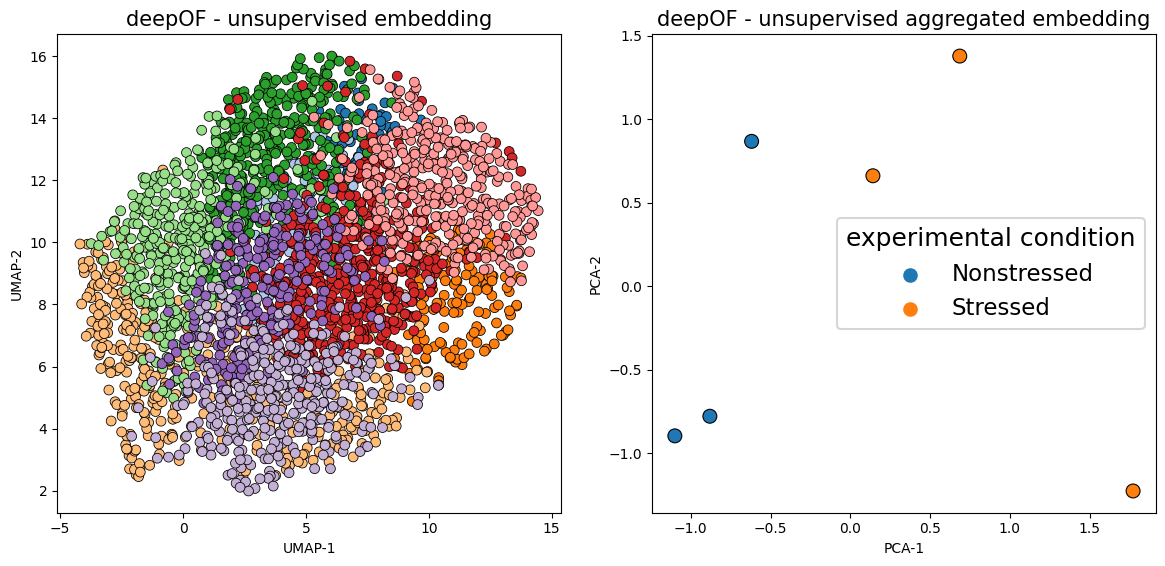

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_embeddings(
    my_deepof_project, 
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments=False,
    samples=500,
    ax=ax1,
    save=False, # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments="time on cluster",
    exp_condition="CSDS",
    show_aggregated_density=False,
#     bin_index=4,
#     bin_size=25*120,
    ax=ax2,
    save=False, # Set to True, or give a custom name, to save the plot,
)

plt.tight_layout()
plt.show()

### Global separation dynamics

Found an optimal_bin at 573 seconds


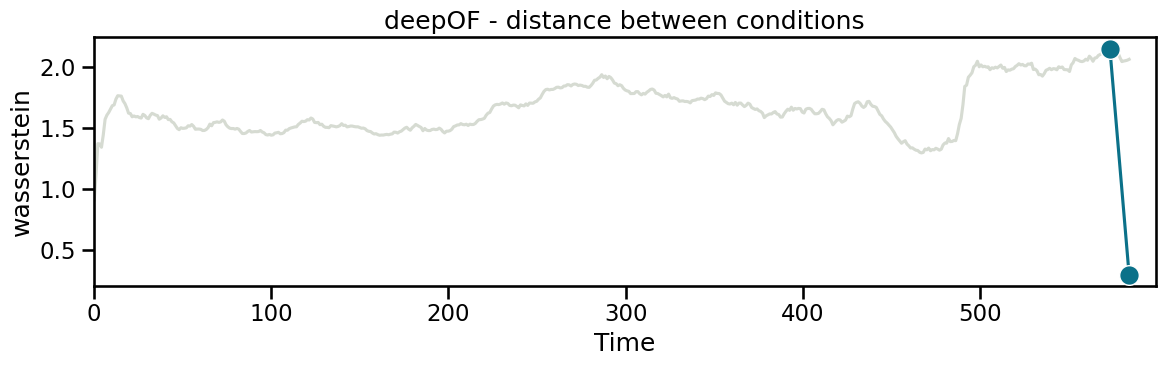

CPU times: user 5.45 s, sys: 26.1 s, total: 31.6 s
Wall time: 3min 14s


In [23]:
%%time
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    
deepof.visuals.plot_distance_between_conditions(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    "CSDS",
    distance_metric="wasserstein",
    n_jobs=-1,
)

plt.show()

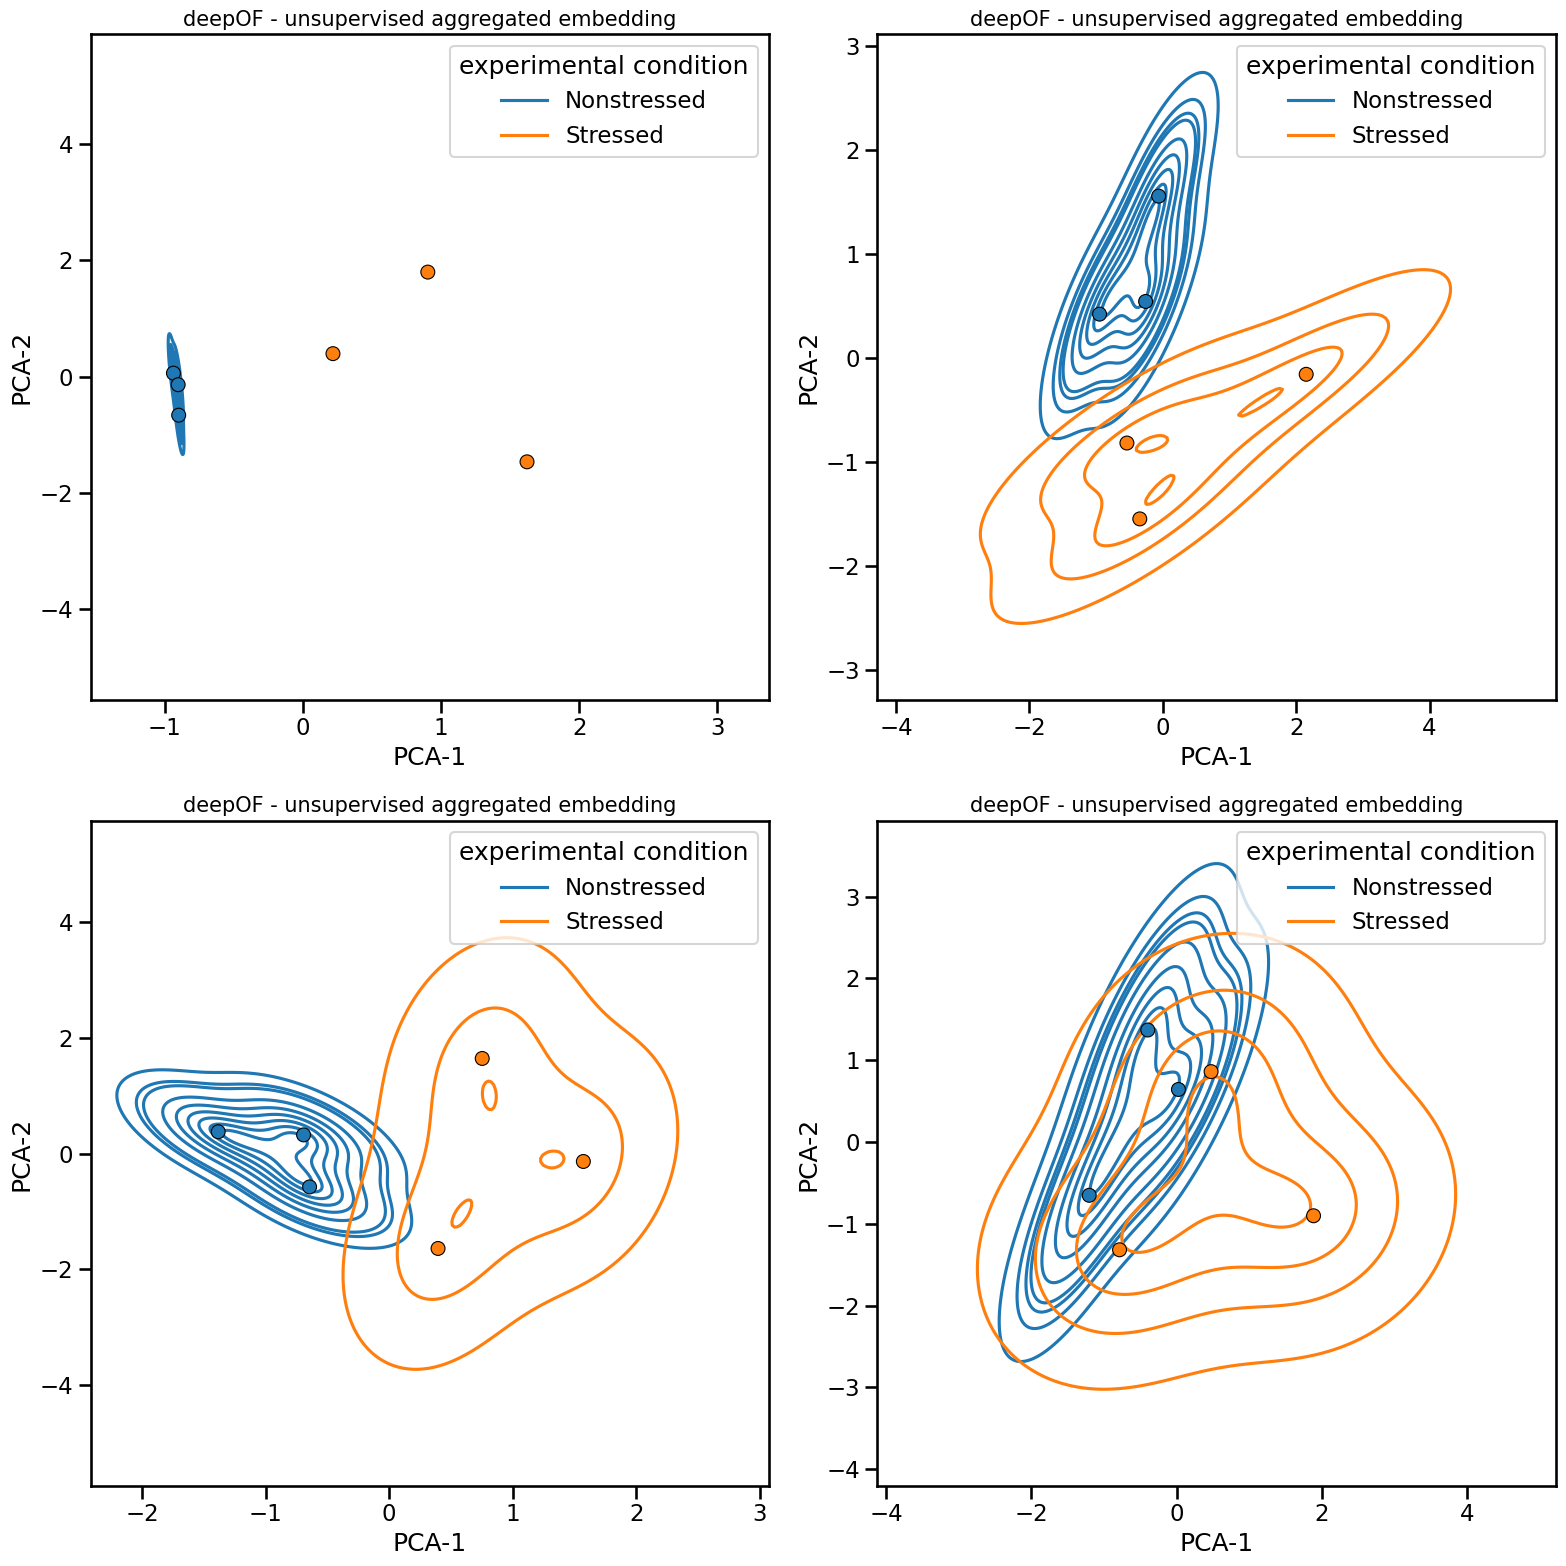

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))


for i, ax in zip(range(4), [ax1, ax2, ax3, ax4]):

    deepof.visuals.plot_embeddings(
        my_deepof_project,
        embeddings, 
        soft_counts,
        breaks,
        aggregate_experiments="time on cluster",
        exp_condition="CSDS",
        show_aggregated_density=True,
        bin_index=i,
        bin_size=126,
        ax=ax,
        save=False, # Set to True, or give a custom name, to save the plot,
    )

plt.tight_layout()
plt.show()

### Exploring cluster enrichment across conditions

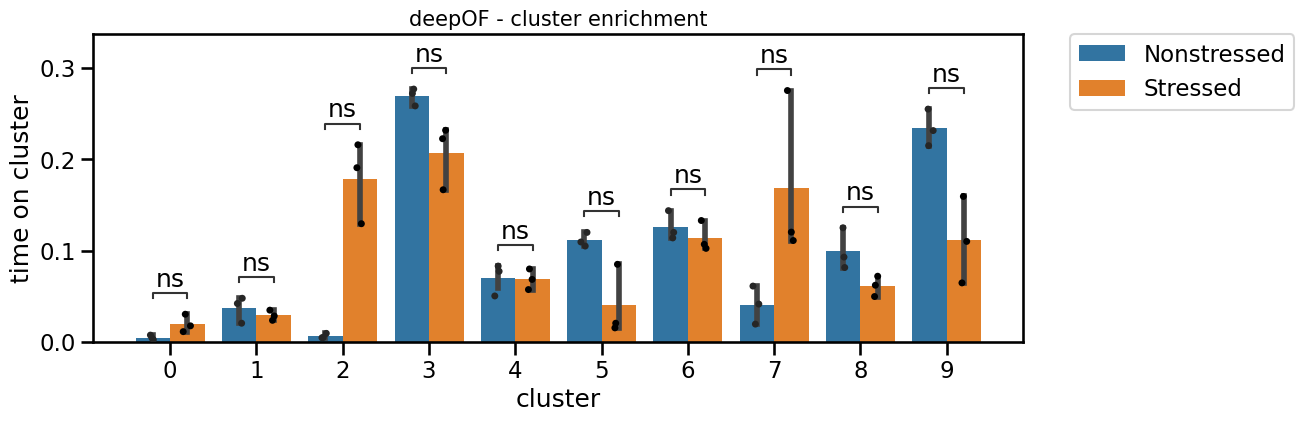

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

deepof.visuals.plot_enrichment(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    normalize=True,
    bin_size=126,
    bin_index=0,
    add_stats="Mann-Whitney",
    exp_condition="CSDS",
    verbose=False,
    ax=ax,
)

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=embeddings,
    cluster_assignments=soft_counts,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=150,
    min_confidence=0.75,
    selected_cluster=2,
    dpi=60,
    center="arena",    
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=embeddings,
    cluster_assignments=soft_counts,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    frame_limit=150,
    min_confidence=0.75,
    selected_cluster=6,
    dpi=60,
    center="arena",
)

html = display.HTML(video)
display.display(html)
plt.close()

### Exploring cluster dynamics across conditions

In [ ]:
# Transition matrices and heatmaps
deepof.visuals.plot_transitions(
    my_deepof_project,
    embeddings,
    soft_counts,
   # cluster=False,
    visualization="heatmaps",
    exp_condition="CSDS",
)

deepof.visuals.plot_transitions(
    my_deepof_project,
    embeddings,
    soft_counts,
    visualization="networks",
    silence_diagonal=True,
    exp_condition="CSDS",
)

# TODO:

# Add option to use umap location on network plots

In [ ]:
# Entropy plots
fig, ax = plt.subplots(1, 1, figsize=(12, 2))

deepof.visuals.plot_stationary_entropy(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    exp_condition="CSDS",
    ax=ax,
)

In [ ]:
fig = plt.figure(figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_gantt( # TODO: Add X axis in seconds, and parameter to overlay events as vertical black bars!
    my_deepof_project, # TODO: restrict time span! it looks noisy
    soft_counts=soft_counts,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
)

### Combining supervised and unsupervised information

#### Visualize global embeddings using the retrieved traits.

#### Visualize animated unsupervised embeddings, coloured by specific traits.

### Interpreting clusters using SHAP

In [ ]:
%%time
csds_chunk_stats, hard_counts, sampled_breaks = deepof.post_hoc.annotate_time_chunks(
    deepof_project=my_deepof_project,
    soft_counts=soft_counts,
    breaks=breaks,
    #supervised_annotations=csds_OF_supervised_annotations,
    kin_derivative=1,
    window_size=13,
    include_distances=True,
    min_confidence=0.9,
    include_angles=True,
    include_areas=True,
    aggregate="mean",
    samples=1500,
)

In [ ]:
%%time
full_cluster_clf, cluster_gbm_performance, groups = deepof.post_hoc.train_supervised_cluster_detectors(
    csds_chunk_stats, hard_counts, sampled_breaks, n_folds=5, verbose=2,
)

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_context("notebook")

deepof.visuals.plot_cluster_detection_performance(
    my_deepof_project,
    csds_chunk_stats,
    cluster_gbm_performance,
    hard_counts,
    groups,
    visualization="confusion_matrix",
)

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_context("talk")

deepof.visuals.plot_cluster_detection_performance(
    my_deepof_project,
    csds_chunk_stats,
    cluster_gbm_performance,
    hard_counts,
    groups,
    visualization="balanced_accuracy",
    save=False,
)

In [ ]:
shap_values, explainer, data_to_explain = deepof.post_hoc.explain_clusters(
    csds_chunk_stats, hard_counts, full_cluster_clf, samples=100
)

In [ ]:
from matplotlib import colors as plt_colors
from ipywidgets import interact
import copy
import numpy as np

# Plot swarm plots per cluster
@interact()
def plot_shap_swarm_per_cluster(
    cluster=["all"] + list(range(10)), save=False,
):
    
    deepof.visuals.plot_shap_swarm_per_cluster(
        my_deepof_project, 
        data_to_explain, 
        shap_values, cluster, 
        save=save,
        show=False,
    )
    
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

### Exporting cluster video snippets

In [ ]:
deepof.visuals.export_annotated_video( # TODO: add exp condition filters to output names
    my_deepof_project,
    soft_counts,
    breaks,
    frame_limit_per_video=100,
)